# 10章
- 以下で実行するコードには確率的な処理が含まれていることがあり、コードの出力結果と本書に記載されている出力例が異なることがあります。

In [1]:
# 10-1
!mkdir chap10
%cd ./chap10

/home/root/work/chap10


In [2]:
# 10-2
!pip install transformers==4.18.0 fugashi==1.1.0 ipadic==1.0.0

In [3]:
# 10-3
import random
import glob
from tqdm import tqdm
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from transformers import BertJapaneseTokenizer, BertModel

# BERTの日本語モデル
MODEL_NAME = 'cl-tohoku/bert-base-japanese-whole-word-masking'

In [4]:
# 10-4
#データのダウンロード
!wget https://www.rondhuit.com/download/ldcc-20140209.tar.gz 
#ファイルの解凍
!tar -zxf ldcc-20140209.tar.gz 

--2022-05-09 16:01:34--  https://www.rondhuit.com/download/ldcc-20140209.tar.gz
Resolving www.rondhuit.com (www.rondhuit.com)... 59.106.19.174
Connecting to www.rondhuit.com (www.rondhuit.com)|59.106.19.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8855190 (8.4M) [application/x-gzip]
Saving to: ‘ldcc-20140209.tar.gz’

ldcc-20140209.tar.g 100%[===================>]   8.44M  3.47MB/s    in 2.4s    

2022-05-09 16:01:39 (3.47 MB/s) - ‘ldcc-20140209.tar.gz’ saved [8855190/8855190]



In [5]:
# 10-5
# カテゴリーのリスト
category_list = [
    'dokujo-tsushin',
    'it-life-hack',
    'kaden-channel',
    'livedoor-homme',
    'movie-enter',
    'peachy',
    'smax',
    'sports-watch',
    'topic-news'
]

# トークナイザとモデルのロード
tokenizer = BertJapaneseTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME)
model = model.cuda()

# 各データの形式を整える
max_length = 256
sentence_vectors = [] # 文章ベクトルを追加していく。
labels = [] # ラベルを追加していく。
for label, category in enumerate(tqdm(category_list)):
    for file in glob.glob(f'./text/{category}/{category}*'):
        # 記事から文章を抜き出し、符号化を行う。
        lines = open(file).read().splitlines()
        text = '\n'.join(lines[3:])
        encoding = tokenizer(
            text, 
            max_length=max_length, 
            padding='max_length', 
            truncation=True, 
            return_tensors='pt'
        )
        encoding = { k: v.cuda() for k, v in encoding.items() } 
        attention_mask = encoding['attention_mask']

        # 文章ベクトルを計算
        # BERTの最終層の出力を平均を計算する。（ただし、[PAD]は除く。）
        with torch.no_grad():
            output = model(**encoding)
            last_hidden_state = output.last_hidden_state 
            averaged_hidden_state = \
                (last_hidden_state*attention_mask.unsqueeze(-1)).sum(1) \
                / attention_mask.sum(1, keepdim=True) 

        # 文章ベクトルとラベルを追加
        sentence_vectors.append(averaged_hidden_state[0].cpu().numpy())
        labels.append(label)

# それぞれをnumpy.ndarrayにする。
sentence_vectors = np.vstack(sentence_vectors)
labels = np.array(labels)

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 9/9 [06:21<00:00, 42.35s/it]


In [6]:
# 10-6
sentence_vectors_pca = PCA(n_components=2).fit_transform(sentence_vectors) 
print(sentence_vectors_pca.shape)

(7367, 2)


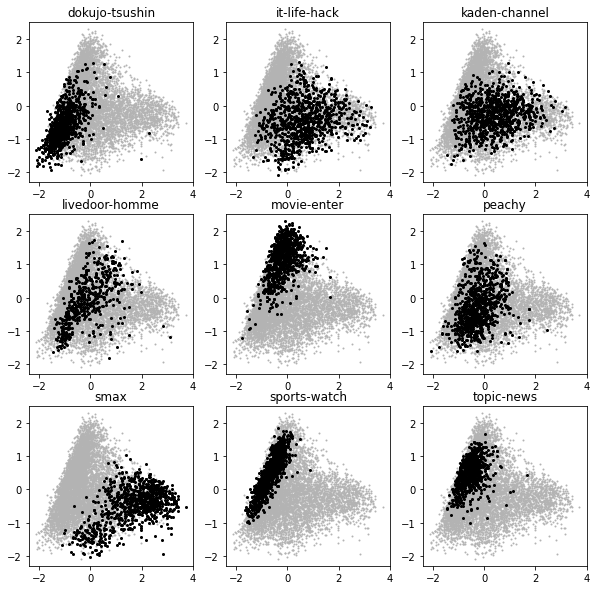

In [7]:
# 10-7
plt.figure(figsize=(10,10))
for label in range(9):
    plt.subplot(3,3,label+1)
    index = labels == label
    plt.plot(
        sentence_vectors_pca[:,0], 
        sentence_vectors_pca[:,1], 
        'o', 
        markersize=1, 
        color=[0.7, 0.7, 0.7]
    )
    plt.plot(
        sentence_vectors_pca[index,0], 
        sentence_vectors_pca[index,1], 
        'o', 
        markersize=2, 
        color='k'
    )
    plt.title(category_list[label])

In [8]:
# 10-8
sentence_vectors_tsne = TSNE(n_components=2).fit_transform(sentence_vectors)    

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


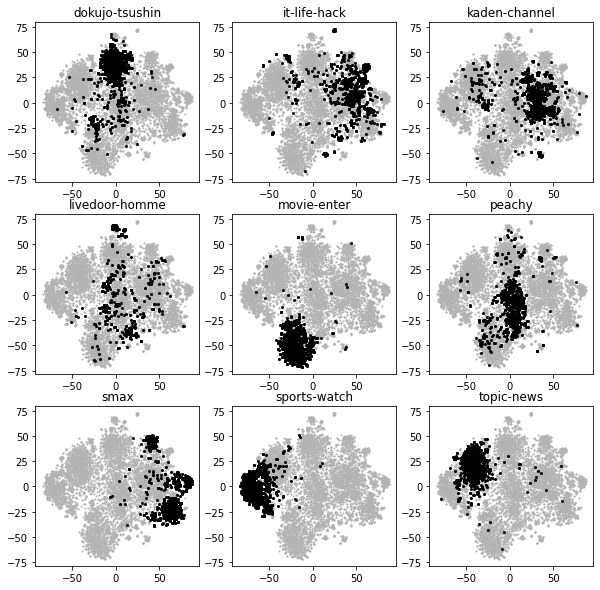

In [9]:
# 10-9
plt.figure(figsize=(10,10))
for label in range(9):
    plt.subplot(3,3,label+1)
    index = labels == label
    plt.plot(
        sentence_vectors_tsne[:,0],
        sentence_vectors_tsne[:,1], 
        'o', 
        markersize=1, 
        color=[0.7, 0.7, 0.7]
    )
    plt.plot(
        sentence_vectors_tsne[index,0],
        sentence_vectors_tsne[index,1], 
        'o',
        markersize=2,
        color='k'
    )
    plt.title(category_list[label])

In [10]:
# 10-10
# 先にノルムを1にしておく。
norm = np.linalg.norm(sentence_vectors, axis=1, keepdims=True) 
sentence_vectors_normalized = sentence_vectors / norm

# 類似度行列を計算する。
# 類似度行列の(i,j)要素はi番目の記事とj番目の記事の類似度を表している。
sim_matrix = sentence_vectors_normalized.dot(sentence_vectors_normalized.T)

# 入力と同じ記事が出力されることを避けるため、
# 類似度行列の対角要素の値を小さくしておく。
np.fill_diagonal(sim_matrix, -1)

# 類似度が高い記事のインデックスを得る
similar_news = sim_matrix.argmax(axis=1) 

# 類似文章検索により選ばれた記事とカテゴリーが同一であった記事の割合を計算
input_news_categories = labels
output_news_categories = labels[similar_news]
num_correct = ( input_news_categories == output_news_categories ).sum()
accuracy = num_correct / labels.shape[0]

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.83
